In [30]:
import os 
os.environ["JAX_PLATFORMS"] = "cpu"
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import h5py 
from train_pybird_emulators.emu_utils.k_arrays import k_emu, k_pybird
from train_pybird_emulators.emu_utils import integrated_model
from train_pybird_emulators.emu_utils import emu_utils
import jax.numpy as jnp
import matplotlib.pyplot as plt 
from pybird.correlator import Correlator


Check how does the original emulator do here! Once again figure out where the spikes happen and why! 

In [31]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".80"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [32]:
fn = "/cluster/scratch/areeves/pk_bank_boss_gaussian_cov_validation_FINAL2/total_data.h5"
# fn= "/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/training_data/new_training_input/total_data.h5"
piece_name = "IRPsct"
model_name = "irpsct_80knots_newbank3_emuinput_jax"

# model_name = "irps11_80knots_newbank_emuinput_pca"
mono = False
quad_hex=False
quad_alone= False
hex_alone= False
n_test=100000
mask_high_k = False

In [33]:

x_train, y_train = emu_utils.get_training_data_from_hdf5(
    fn,
    piece_name,
    n_test,
    mono=mono,
    quad_hex=quad_hex,
    quad_alone=quad_alone,
    hex_alone=hex_alone,
    mask_high_k=False,
)

if mask_high_k:
    if k_emu.shape[0] != y_train.shape[1]:
        num_patterns = y_train.shape[1] // k_pybird.shape[0]
        single_mask = np.array(
            [True] * k_emu.shape[0]
            + [False] * (k_pybird.shape[0] - k_emu.shape[0])
        )

        # Repeat the mask for num_patterns times
        full_mask = np.tile(single_mask, num_patterns)
        # Apply the mask to remove the high k parts of the array
        y_train = y_train[:, full_mask]
        y_train, x_train = emu_utils.remove_nan_rows_from_both_arrays(
            y_train, x_train
        )

# Filter out bad indices
if piece_name is not None:
    print(f"filtering out bad indices for piece {piece_name}")

    condition_1 = np.any(x_train[:, :-2] > 0, axis=1)
    condition_2 = x_train[:, -1] < 0
    condition_3 = x_train[:, -2] < 0

    gradients = np.abs(np.diff(y_train, axis=1))

    # gradient_threshold = np.quantile(
    #     gradients, 0.999
    # )  # top 15% of gradients

    # # spikes typically happen around high k
    # spike_positions = np.arange(
    #     k_emu.shape[0] - 1, gradients.shape[1], k_emu.shape[0]
    # )  # Adjust for 0-index and diff output size

    # # Condition to identify rows with gradient spikes at specific positions
    # condition_4 = np.any(
    #     gradients[:, spike_positions] > gradient_threshold, axis=1
    # )

    # bad_inds = np.where(condition_1 | condition_2 | condition_3)[0]

    bad_inds = np.where(condition_1 | condition_2 | condition_3)[0]


    # condition_5 = x_train[:, -2] > 35000

    # gradients_first_5 = np.diff(x_train[:, :6], axis=1)  # Shape: (num_samples, 10)

    # # Identify negative gradients
    # negative_gradients = gradients_first_5 < 0  # Shape: (num_samples, 10)

    # condition_6 = np.any(negative_gradients, axis=1)


    # bad_inds = np.where(
    #     condition_1 | condition_2 | condition_3 | condition_4 | condition_5
    # )[0]
    # condition_4 = x_train[:, -2] > 20000

    # gradients_first_5 = np.diff(x_train[:, :6], axis=1)  # Shape: (num_samples, 5)
    # negative_gradients = gradients_first_5 < 0  # Shape: (num_samples, 5)
    # condition_5 = np.any(negative_gradients, axis=1)

    # bad_inds = np.where(condition_1 | condition_2 | condition_3  | condition_5)[0]
    
    if piece_name.startswith("I"):
        print("training IR piece... going to filter out large gradients")
        # Calculate the absolute gradients along each row
        gradients = np.abs(np.diff(y_train, axis=1))

        gradient_threshold = np.quantile(
            gradients, 0.90
        )  # top 30% of gradients

        # spikes typically happen around high k
        spike_positions = np.arange(
            k_emu.shape[0] - 1, gradients.shape[1], k_emu.shape[0]
        )  # Adjust for 0-index and diff output size

        # Condition to identify rows with gradient spikes at specific positions
        condition_4 = np.any(
            gradients[:, spike_positions] > gradient_threshold, axis=1
        )

        condition_5 = x_train[:, -2] > 20000

        # bad_inds = np.where(
        #     condition_1 | condition_2 | condition_3 | condition_4 | condition_5
        # )[0]

        bad_inds = np.where(
            condition_1 | condition_2 | condition_3
        )[0]
    
if not piece_name.startswith("I"):
    print("training non-IR piece... going to remove last two columns of x_train")
    x_train = x_train[:, :-2]


print(f"removing {len(bad_inds)} bad indices")
x_train = np.delete(x_train, bad_inds, axis=0)
y_train = np.delete(y_train, bad_inds, axis=0)

# # Are there places where all the columns in the data are zero?
zero_columns = np.where(np.sum(np.abs(y_train), axis=0) == 0)[0]

# if zero_columns is not None and zero_columns.shape[0] > 0:
#     print(f"removing zero columns for piece {piece_name}")
#     # remove and save zero columns indices
#     y_train = np.delete(y_train, zero_columns, axis=1)
#     print("zero columns", zero_columns)    

24-11-26 17:46:33 train_pybi INF   total number of available training points: 90000 
24-11-26 17:46:33 train_pybi INF   Available keys in the file: <KeysViewHDF5 ['D', 'IRPs11', 'IRPsct', 'IRPsloop', 'Ploopl', 'bpk_resum_False', 'bpk_resum_True', 'emu_inputs', 'f', 'kk', 'params', 'pk_lin']> 
xtrain shape (90000, 82)
filtering out bad indices for piece IRPsct
training IR piece... going to filter out large gradients
removing 1154 bad indices


In [34]:
testing_spectra = y_train

In [35]:
testing_spectra.shape 

(88846, 1386)

In [36]:
x_train.shape 

(88846, 82)

In [37]:
np.where(testing_spectra[0]==0)

(array([   0,    1,    2,    3,    4,    5,    6,    7,   77,   78,   79,
          80,   81,   82,   83,   84,  154,  155,  156,  157,  158,  159,
         160,  161,  231,  232,  233,  234,  235,  236,  237,  238,  308,
         309,  310,  311,  312,  313,  314,  315,  385,  386,  387,  388,
         389,  390,  391,  392,  462,  463,  464,  465,  466,  467,  468,
         469,  539,  540,  541,  542,  543,  544,  545,  546,  616,  617,
         618,  619,  620,  621,  622,  623,  693,  694,  695,  696,  697,
         698,  699,  700,  770,  771,  772,  773,  774,  775,  776,  777,
         847,  848,  849,  850,  851,  852,  853,  854,  924,  925,  926,
         927,  928,  929,  930,  931, 1001, 1002, 1003, 1004, 1005, 1006,
        1007, 1008, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1155,
        1156, 1157, 1158, 1159, 1160, 1161, 1162, 1232, 1233, 1234, 1235,
        1236, 1237, 1238, 1239, 1309, 1310, 1311, 1312, 1313, 1314, 1315,
        1316]),)

In [38]:
from pybird import config 
config.set_jax_enabled(True) # Enable JAX by setting the config Class

from pybird import integrated_model_jax
test_model = integrated_model_jax.IntegratedModel(None,None,None,None)
# test_model = integrated_model.IntegratedModel(None,None,None,None)
# test_model.restore(f"/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/saved_models/{model_name}")
test_model.restore(f"/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/saved_models/{model_name}_model.h5")

jax: on


In [39]:
predicted_testing_spectra = test_model.predict(x_train)

(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)


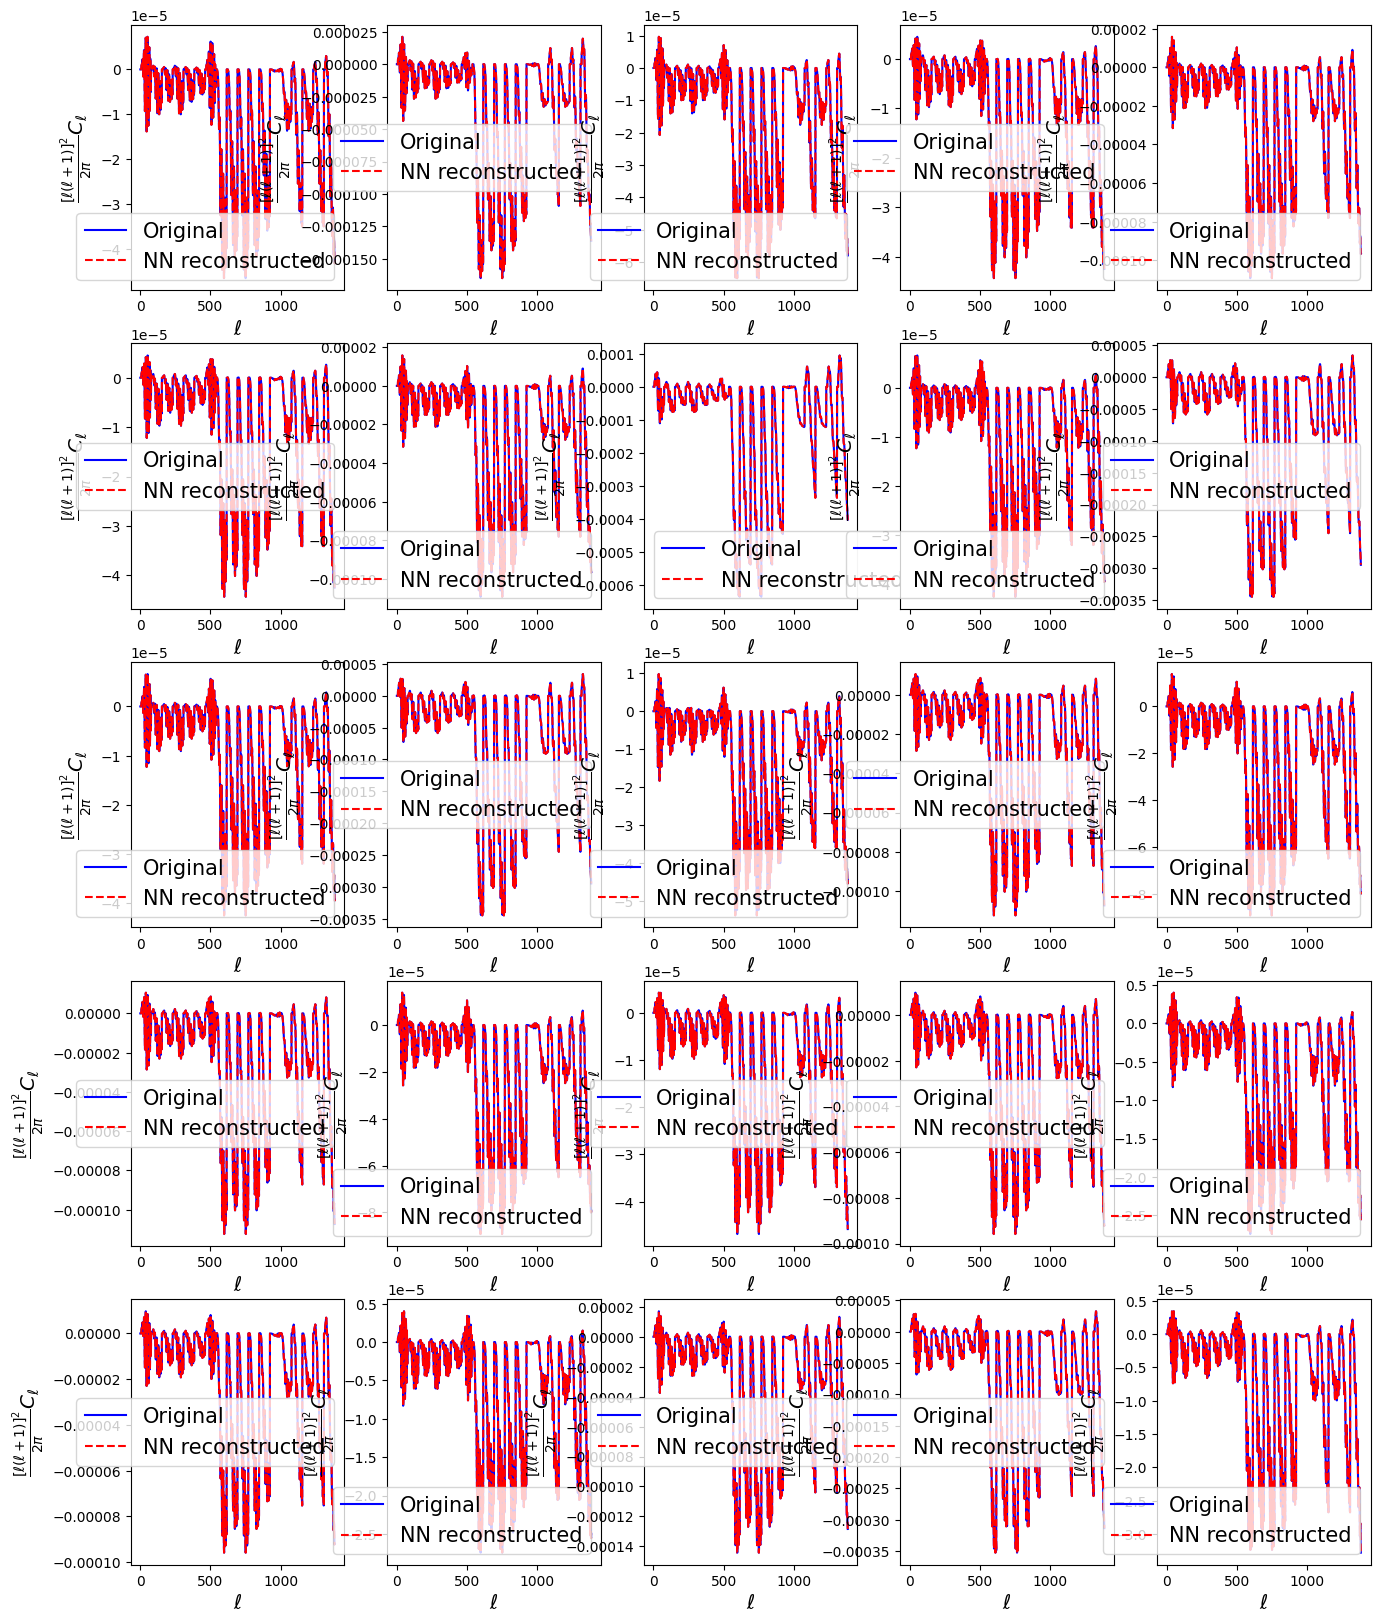

In [40]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16,20))
for j in range(5):
    for i in range(5):
        pred = predicted_testing_spectra[i+j*3]
        true = testing_spectra[i+j*3]
        print(true.shape)
        ell_range = np.arange(true.shape[0])
        ax[j, i].plot(ell_range, true, 'blue', label = 'Original')
        ax[j, i].plot(ell_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
        ax[j, i].set_xlabel('$\ell$', fontsize='x-large')
        ax[j, i].set_ylabel('$\\frac{[\ell(\ell+1)]^2}{2 \pi} C_\ell$', fontsize='x-large')
        ax[j, i].legend(fontsize=15)
plt.savefig('examples_reconstruction_PP.pdf')

In [41]:
column_indices = jnp.arange(testing_spectra.shape[1])
mask = ~jnp.isin(column_indices, zero_columns) 

In [42]:
testing_spectra.shape 

(88846, 1386)

In [43]:
testing_spectra[:, mask].shape

(88846, 1242)

In [44]:
grid = (testing_spectra[:, mask]-predicted_testing_spectra[:, mask])/testing_spectra[:,mask]

In [45]:
percentiles = np.zeros((4, grid.shape[1]))
percentiles[0] = np.percentile(grid, 68, axis = 0)
percentiles[1] = np.percentile(grid, 95, axis = 0)
percentiles[2] = np.percentile(grid, 99, axis = 0)
percentiles[3] = np.percentile(grid, 99.9, axis = 0)

In [46]:
grid.shape 

(88846, 1242)

Text(0, 0.5, '$\\Delta P^g_{\\ell}/\\sigma(P^g_{\\ell})$')

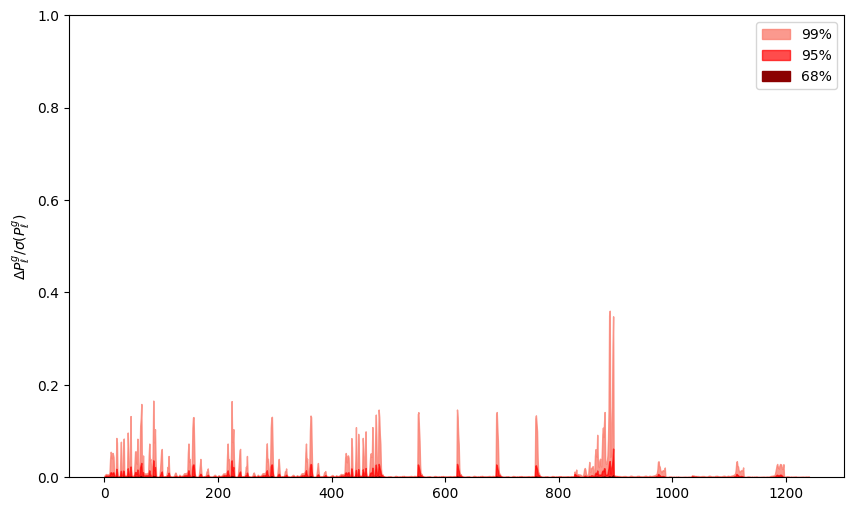

In [47]:
fig, ax = plt.subplots(figsize =(10,6))

# set some space between the subplots
ell_range = np.arange(grid.shape[1])
fig.subplots_adjust(hspace=0.8)
ax.fill_between(ell_range, 0, percentiles[2], color = 'salmon', label = '99%', alpha=0.8)
ax.fill_between(ell_range, 0, percentiles[1], color = 'red', label = '95%', alpha = 0.7)
ax.fill_between(ell_range, 0, percentiles[0], color = 'darkred', label = '68%', alpha = 1)
ax.legend()
ax.set_ylim([0,1])
ax.set_ylabel(r"$\Delta P^g_{\ell}/\sigma(P^g_{\ell})$")

In [48]:
testing_spectra.shape 

(88846, 1386)

In [49]:
(1-np.median(np.abs((testing_spectra[:, mask]-predicted_testing_spectra[:, mask])/testing_spectra[:, mask])))*100

99.97529369938624

In [50]:
(1-np.mean(np.abs((testing_spectra[:, mask]-predicted_testing_spectra[:, mask])/testing_spectra[:, mask])))*100

98.98917278706992

In [51]:
zero_columns

array([   0,    1,    2,    3,    4,    5,    6,    7,   77,   78,   79,
         80,   81,   82,   83,   84,  154,  155,  156,  157,  158,  159,
        160,  161,  231,  232,  233,  234,  235,  236,  237,  238,  308,
        309,  310,  311,  312,  313,  314,  315,  385,  386,  387,  388,
        389,  390,  391,  392,  462,  463,  464,  465,  466,  467,  468,
        469,  539,  540,  541,  542,  543,  544,  545,  546,  616,  617,
        618,  619,  620,  621,  622,  623,  693,  694,  695,  696,  697,
        698,  699,  700,  770,  771,  772,  773,  774,  775,  776,  777,
        847,  848,  849,  850,  851,  852,  853,  854,  924,  925,  926,
        927,  928,  929,  930,  931, 1001, 1002, 1003, 1004, 1005, 1006,
       1007, 1008, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1155,
       1156, 1157, 1158, 1159, 1160, 1161, 1162, 1232, 1233, 1234, 1235,
       1236, 1237, 1238, 1239, 1309, 1310, 1311, 1312, 1313, 1314, 1315,
       1316])

In [52]:
knots = np.load("/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/knots_data/final_knots_80.npy")

In [53]:
knots 

array([1.00000000e-04, 1.46002162e-04, 2.13166312e-04, 3.11227423e-04,
       4.54398764e-04, 6.63432018e-04, 9.68625086e-04, 1.41421356e-03,
       2.06478237e-03, 3.01462689e-03, 4.40142042e-03, 6.42616895e-03,
       9.38234557e-03, 1.36984273e-02, 2.00000000e-02, 2.10000000e-02,
       2.39166870e-02, 2.72384723e-02, 3.10216198e-02, 3.53302082e-02,
       4.02372158e-02, 4.58257569e-02, 5.21904898e-02, 5.94392195e-02,
       6.76947243e-02, 7.70968349e-02, 8.78048033e-02, 1.00000000e-01,
       1.10000000e-01, 1.14064792e-01, 1.18279789e-01, 1.22650542e-01,
       1.27182805e-01, 1.31882548e-01, 1.36755958e-01, 1.41809454e-01,
       1.47049690e-01, 1.52483567e-01, 1.58118240e-01, 1.63961129e-01,
       1.70019928e-01, 1.76302616e-01, 1.82817466e-01, 1.89573057e-01,
       1.96578285e-01, 2.03842375e-01, 2.11374892e-01, 2.19185756e-01,
       2.27285252e-01, 2.35684046e-01, 2.44393197e-01, 2.53424175e-01,
       2.62788871e-01, 2.72499618e-01, 2.82569203e-01, 2.93010886e-01,
      

In [54]:
knots2 = np.load("/cluster/work/refregier/alexree/local_packages/pybird_emu/data/emu/knots.npy")

In [55]:
knots2/knots 

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [56]:
zero_columns 

array([   0,    1,    2,    3,    4,    5,    6,    7,   77,   78,   79,
         80,   81,   82,   83,   84,  154,  155,  156,  157,  158,  159,
        160,  161,  231,  232,  233,  234,  235,  236,  237,  238,  308,
        309,  310,  311,  312,  313,  314,  315,  385,  386,  387,  388,
        389,  390,  391,  392,  462,  463,  464,  465,  466,  467,  468,
        469,  539,  540,  541,  542,  543,  544,  545,  546,  616,  617,
        618,  619,  620,  621,  622,  623,  693,  694,  695,  696,  697,
        698,  699,  700,  770,  771,  772,  773,  774,  775,  776,  777,
        847,  848,  849,  850,  851,  852,  853,  854,  924,  925,  926,
        927,  928,  929,  930,  931, 1001, 1002, 1003, 1004, 1005, 1006,
       1007, 1008, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1155,
       1156, 1157, 1158, 1159, 1160, 1161, 1162, 1232, 1233, 1234, 1235,
       1236, 1237, 1238, 1239, 1309, 1310, 1311, 1312, 1313, 1314, 1315,
       1316])

In [57]:
N = Correlator()
# Set up pybird in time unspecified mode for the computation of the pybird pieces training data
N.set(
    {
        "output": "bPk",
        "multipole": 3,
        "kmax": 0.6,
        "fftaccboost": 2,
        "with_resum": True,
        "with_exact_time": True,
        "with_time": False,  # time unspecified
        "km": 1.0,
        "kr": 1.0,
        "nd": 3e-4,
        "eft_basis": "eftoflss",
        "with_stoch": True,
    }
)

# internal pybird k-array
k_pybird = N.co.k

loading matrices!


In [58]:
k_pybird.shape 

(97,)